#Laboratorio 9: Redes Neuronales

ME4707 - Robótica - Semestre 2021-1

Profesor: Juan C. Zagal - Auxiliar: Cristián Herrera - Laboratorios: Raimundo Lorca


# Problema: Iris Dataset

Se busca desarrollar un modelo capaz de clasificar cada flor, considerando las dimensiones de esta, en específico, el largo y ancho del sépalo y pétalo de cada flor. Se trabajará con un base de datos con 150 instancias, con información de 3 tipos de flores distintas.

<img src="https://raw.githubusercontent.com/RaimundoLorca/Practico_taller/main/iris.jpg" height="300">

De derecha a izquierda: Iris setosa, Iris versicolor y Iris virginica.

In [ ]:
!git clone https://github.com/cherrerab/roboticafcfm.git
%cd /content/roboticafcfm

fatal: destination path 'roboticafcfm' already exists and is not an empty directory.
/content/roboticafcfm


##Dataset

Vamos a ocupar el dataset **iris** disponible en sklearn, que como hemos visto contiene 150 **instancias** (filas) de 3 **clases** diferentes de flores. El método **load_iris** permite cargar el dataset.

Las filas siguientes son registros de datos, un ejemplo por línea, donde:

*   Los primeros cuatro campos son características : estas son las características de una muestra. Aquí, los campos contienen números flotantes que representan las medidas de las flores.
*   La última columna es la etiqueta, este es el valor que queremos predecir. Para este conjunto de datos, es un valor entero de 0, 1 o 2 que corresponde al nombre de una flor.



In [ ]:
from sklearn.datasets import load_iris
import pandas as pd

iris = load_iris() #Cargar dataset
iris_df = pd.read_csv("https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv")

X = iris.data      ## Datos, caracteristicas o features de cada flor. 
Y = iris.target    ## Clase para cada instancia anterior.

In [ ]:
iris_df.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


Para saber cuáles son las clases: **0 Corresponde a setosa; 
1 Corresponde a versicolor;
2 Corresponde a virginica**

In [ ]:
print(iris.target)  # mostramos todas las clases de X 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


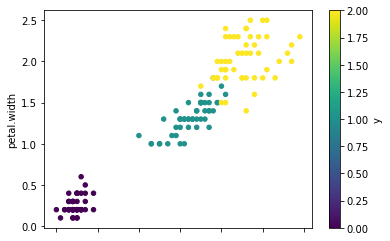

In [ ]:
from sklearn import preprocessing
import matplotlib.pyplot as plt

#Ignorar esto
X = pd.DataFrame(iris_df[["sepal.length","sepal.width","petal.length","petal.width"]])
y = list(iris_df["variety"])
le = preprocessing.LabelEncoder() #Encode target labels with value between 0 and n_classes-1.
y = le.fit_transform(y)
iris_df["y"] = y

#Visualizar datos
iris_df.plot.scatter("petal.length","petal.width", c="y", colormap='viridis')

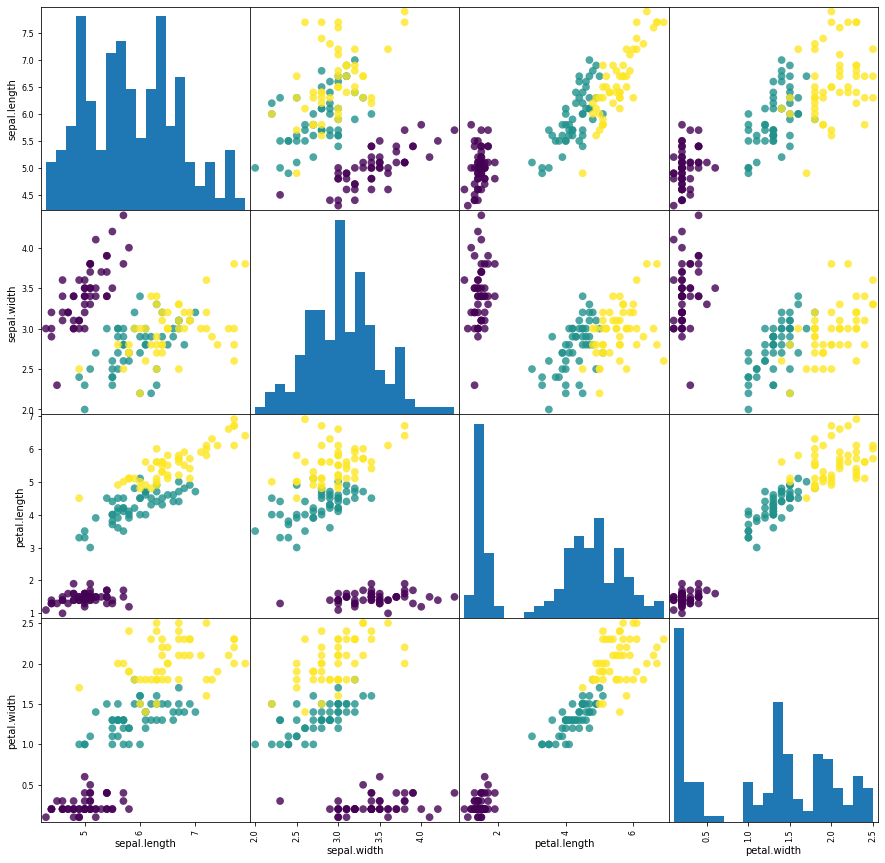

In [ ]:
#Visualisación general del dataset
pd.plotting.scatter_matrix(X, c=y, figsize=(15, 15), marker='o',
                                 hist_kwds={'bins': 20}, s=60, alpha=.8);

##Data Splitting

Una vez se tiene el dataset, vamos a dividirlo en tres: **training_set**, **val_set** y **test_set**.



*   El **training_set** nos permite aprender de ejemplos y ajustar el clasificador de acuerdo a éstos. 
*   El **val_set** nos permite monitorear directamente el desempeño del modelo sobre el conjunto de evaluación. 
*   El **test_set** nos permitirá comprender qué tan bien **generalizamos** con nuevos datos.


 En **scikit-learn** existe un método llamado **train_test_split**, que nos permite hacer esta separación de manera aleatoria y estratificada (manteniendo la proporción de clases entre las instancias de cada set).

In [ ]:
from sklearn.model_selection import train_test_split


# Generar sets de datos de training y testing
# la varibale test_size permite controlar la proporción entre los datos de testing y training.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2 )

# Adicionalmente generaremos un conjunto de validación
# este conjunto será utilizado para monitorear la generalización del modelo
# sin utilizar el conjunto de testing.
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1,
                                                  random_state = 0)

print('Cantidad de datos de entrenamiento: ',Y_train.shape)
print('Cantidad de datos de validación: ',Y_val.shape)
print('Cantidad de datos de testeo: ',Y_test.shape)

Cantidad de datos de entrenamiento:  (108,)
Cantidad de datos de validación:  (12,)
Cantidad de datos de testeo:  (30,)


In [ ]:
from tensorflow.keras.utils import to_categorical

# Dado que las etiquetas no vienen con one-hot encoding las transformamos a estas.
# one-hot-encoding consiste en codificar las etiquetas de la forma [0, 0, 1]
# cuando, por ejemplo, se tienen tres clases. Así, esta estructura es compatible
# con la salida de una capa softmax.

#Cambiar la etiqueta a one hot vector

# [0]--->[1 0 0]
# [1]--->[0 1 0]
# [2]--->[0 0 1]

#Se puede utilizar la función to_categorical de keras.utils
Y_train = to_categorical(Y_train,num_classes=3)
Y_val = to_categorical(Y_val,num_classes=3)
Y_test = to_categorical(Y_test,num_classes=3)

##Model Setup

En términos generales, compondremos nuestro modelo de una serie de capas, que se encargarán de procesar la información y los patrones de los datos de entrada hasta una última capa con únicamente 3 nodos que determinarán la clase de la flor (Setosa, Versicolor o Virginica).

<img src="https://raw.githubusercontent.com/RaimundoLorca/Practico_taller/main/arquitectura_red2.jpeg" height="350">

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout

# inicializar modelo keras.Sequential
model = Sequential()

# ahora podemos ir agregando secuencialmente capas nuestro modelo
# mediante el método keras.Model.add

# ---
# primero debemos agregar nuestra capa Input donde debemos especificar
# las dimensiones de los datos que se ingresarán al modelo
input_dim = ( 4, )
model.add( Input( shape=input_dim ) )

# ---
# ahora debemos ir agregando nuestras capas Dense.
# https://keras.io/api/layers/core_layers/dense/

# las keras.layers.Dense reciben la cantidad de nodos o units dentro
# de la capa y la función de activación que operarán.
# https://keras.io/api/layers/activations/
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))



# ---
# por último debemos configurar nuestra capa de salida
# dado que el modelo consiste en uno de clasificación emplearemos
# la función softmax, donde cada nodo indicará la probabilidad de que
# los datos correspondan a una de las etiquetas o estados de salud.
labels_num = 3
model.add( Dense(units=labels_num, activation='softmax') )


Una vez seteada la arquitectura de la red, se puede imprimir información sobre el modelo generado, Keras cuenta con el método `keras.Model.summary` para presentar un resumen de la arquitectura de la red neuronal.

In [ ]:
# imprimir object o clase del modelo
print('type(model): ', type(model))

# imprimir resumen del modelo
print('\nclassification model summary:\n')
model.summary()

type(model):  <class 'keras.engine.sequential.Sequential'>

classification model summary:

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 256)               1280      
_________________________________________________________________
dense_15 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 195       
Total params: 42,627
Trainable params: 42,627
Non-trainable params: 0
_________________________________________________________________


## Compile Model

Antes de poner a entrenar al modelo, es necesario realizar unas configuraciones adicionales. En particular, debemos especificar la función de pérdida o `loss function` que se optimizará durante el entrenamiento y el método de optimización como SGD o Adam.


In [ ]:
from keras.optimizers import Adam

# configurar optimizador Adam
# https://keras.io/api/optimizers/adam/
opt = Adam(learning_rate=1e-3)

# ---
# compilar modelo siguiendo como función de pérdida
# la categorical crossentropy
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Model Training

Hemos llegado a la parte final del proceso, para entrenar nuestro modelo debemos especificar los sets que utilizaremos para el proceso `(X_train, Y_train)`, la cantidad de `epochs` que durará el entrenamiento, y el `batch size` de muestras que se irán entregando al modelo a medida que este va iterativamente ajustando sus parámetros.



Epoch 1/20
4/4 [==============================] - 1s 108ms/step - loss: 1.0940 - accuracy: 0.6771 - val_loss: 0.8617 - val_accuracy: 0.5833
Epoch 2/20
4/4 [==============================] - 0s 11ms/step - loss: 0.7891 - accuracy: 0.7179 - val_loss: 0.7700 - val_accuracy: 0.5833
Epoch 3/20
4/4 [==============================] - 0s 10ms/step - loss: 0.6394 - accuracy: 0.7117 - val_loss: 0.6730 - val_accuracy: 0.7500
Epoch 4/20
4/4 [==============================] - 0s 10ms/step - loss: 0.5235 - accuracy: 0.7571 - val_loss: 0.6031 - val_accuracy: 0.7500
Epoch 5/20
4/4 [==============================] - 0s 11ms/step - loss: 0.4654 - accuracy: 0.9063 - val_loss: 0.5413 - val_accuracy: 0.8333
Epoch 6/20
4/4 [==============================] - 0s 10ms/step - loss: 0.3935 - accuracy: 0.8897 - val_loss: 0.5068 - val_accuracy: 0.7500
Epoch 7/20
4/4 [==============================] - 0s 12ms/step - loss: 0.3763 - accuracy: 0.8703 - val_loss: 0.4765 - val_accuracy: 0.9167
Epoch 8/20
4/4 [==========

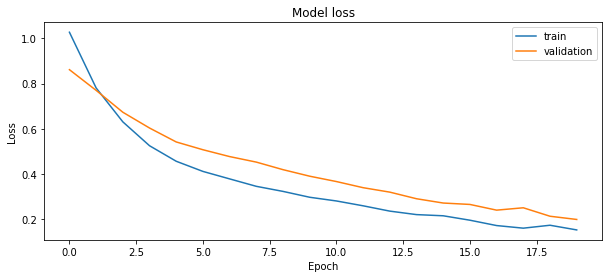

In [ ]:
from utils import plot_loss_function

# realizar rutina de entrenamiento
train_history = model.fit(X_train, Y_train,
                          batch_size=32, epochs=20,
                          validation_data=(X_val, Y_val) )

# plot gráfico de función de pérdida
plot_loss_function(train_history, figsize=(10,4))

## Model Evaluation

Una vez entrenado el modelo, hay que evaluar su desempeño. Para lograr esto se utilizan el set de testeo que teniamos guardado `(X_test, Y_test)`. Nuestro modelo va a predecir la clase en función de `X_test`, entregando un set llamado `Y_pred`, el cual será comparado con el set `Y_test`.

Para utilizar el `keras.Model` sobre nuevos datos de clasificación, conviene utilizar el método `keras.Sequential.predict`.

testing accuracy: 1.000


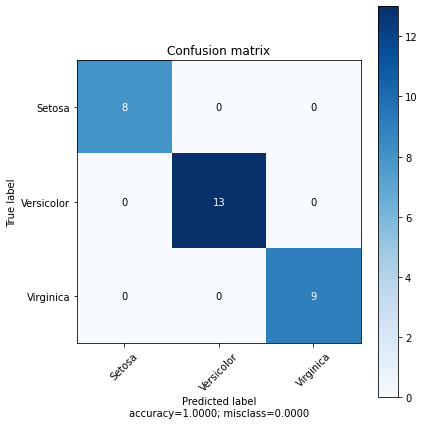

In [ ]:
from sklearn.metrics import accuracy_score
from utils import plot_classification_map
from utils import plot_confusion_matrix
import numpy as np

# obtener predicciones de X_test
Y_pred = model.predict(X_test)

# para que el resultado nos sea más intuitivo transformaremos
# las etiquetas nuevamente a non one-hot-encoding
# utilizando np.argmax
Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

# calcular accuracy de la clasificación.
accuracy = accuracy_score(Y_true, Y_pred)
print('testing accuracy: {:1.3f}'.format(accuracy))

# matriz de confusión
plot_confusion_matrix(Y_true, Y_pred,
                      target_names=['Setosa', 'Versicolor', 'Virginica'], figsize=(6, 6))